# 3. Classifier interpretability

In this section we train two types of models: a decision tree, and a convolutional neural network, to inspect "which model is more interpretable?".

In the following steps:

1. Process the CIFAR-10 dataset.
2. Define and train a convolutional neural network (CNN) classifier using PyTorch.
3. Interpret the CNN using the 'activation maximization' technique.
4. Define and train a decision tree classifier.
5. Interpret the decision tree and

**Run the code below** to import required packages.


In [99]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report

**Run the code cell below** to download the data in a folder called 'datasets' if it's not already downloaded.



In [100]:
def load_data(root='datasets/'):

    # normalize values from [0, 1] to [-1, 1]
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, std
    batch_size = 5

    trainset = torchvision.datasets.CIFAR10(root=root, train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=root, train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)    

    
    return trainloader, testloader



# Get the train_oader and testloader
trainloader, testloader = load_data()


Files already downloaded and verified
Files already downloaded and verified


 **Run the code below** to define methods to read, unpickles the data batches and convert them into np arrays for training and testing. 

In [101]:
def unpickle(filepath, filename):
    """
    read the file and return the file contents
    
    @param filepath: file relative path
    @param filename: file name
    """
    with open(os.path.join(filepath, filename), 'rb') as fo:            
        file = pickle.load(fo, encoding='bytes')
    return file

def get_train_test():

    # the folder path where it stores the CIFAR-10 training batches files
    data_path = 'datasets/cifar-10-batches-py'
        
    # file names for training batches
    training_batches = ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5')        
       
    # temporary variables for reading files
    train_data = None
    train_labels = None
        
    for filename in training_batches:
        # read the file contents
        dict_train = unpickle(data_path, filename)
        file_data = dict_train[b'data']
        file_labels = dict_train[b'labels']
            
        # append the file contents in each batch to train_data and train_labels
        if train_data is None and train_labels is None:
            # for the first training batch
            train_data = file_data
            train_labels = file_labels
        else:
            # for the following training batches
            #Stack arrays in sequence vertically (row wise) using vstack
            # This is equivalent to concatenation along the 
            # first axis after 1-D arrays of shape (N,) have been reshaped to (1,N). 
            train_data = np.vstack((train_data, file_data))
            # stack arrays in sequence horizontally (column wise) using hstack
            train_labels = np.hstack((train_labels, file_labels))
    x_train = train_data      # (50000, 3072)
    y_train = train_labels    # (50000,)
    
    # read test batch file
    test_batch = 'test_batch'
    
    # read the file contents
    dict_test = unpickle(data_path, test_batch)
        
    x_test = dict_test[b'data']      # (10000, 3072)
    y_test = dict_test[b'labels']    # (10000,)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test();

**Run the code cell below** to do Cross validation using GridSearch over the hyper-parameters: criterion and max_depth to find the best Decision Tree classifier:

Running the following code cell takes about 9 minues on a Unix platform.

In [104]:
# define a decision tree classifier
#To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer
dec_tree = DecisionTreeClassifier(random_state=0)
# define parameters range
#criterion = ['gini', 'entropy']
#max_depth = [2,4,6,8]
params = {'max_depth': [2,4,6,8], 'criterion': ['gini', 'entropy']}
#params = dict(dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)

# apply grid search cross validation
cv_grid = GridSearchCV(estimator=dec_tree, 
                       cv=3,    # 3-fold cross-validation
                       n_jobs=-1,    # use all processors to train
                       param_grid=params)

cv_grid.fit(x_train, y_train)

# get the best estimator
gridcv_best_estimator = cv_grid.best_estimator_

# print the results (Accuracy and Recall scores(macro because all classes need to be treated equally))
print('Best GridSearch estimator: ', gridcv_best_estimator)

print('Accuracy on the 50000 train images: %.2f %%' 
      % (100 * gridcv_best_estimator.score(X=x_train, y=y_train)))
print('Accuracy on the 10000 test images: %.2f %%' 
      % (100 * gridcv_best_estimator.score(X=x_test, y=y_test)))
print("Recall (average='macro') on the 50000 train images: %.3f" 
      % (recall_score(y_true=y_train, y_pred=gridcv_best_estimator.predict(x_train), average='macro')))
print("Recall (average='macro') on the 10000 test images: %.3f" 
      % (recall_score(y_true=y_test, y_pred=gridcv_best_estimator.predict(x_test), average='macro')))

Best GridSearch estimator:  DecisionTreeClassifier(max_depth=8, random_state=0)
Accuracy on the 50000 train images: 34.96 %
Accuracy on the 10000 test images: 30.25 %
Recall (average='macro') on the 50000 train images: 0.350
Recall (average='macro') on the 10000 test images: 0.303


**Run the code cell below** to plot the best tree:

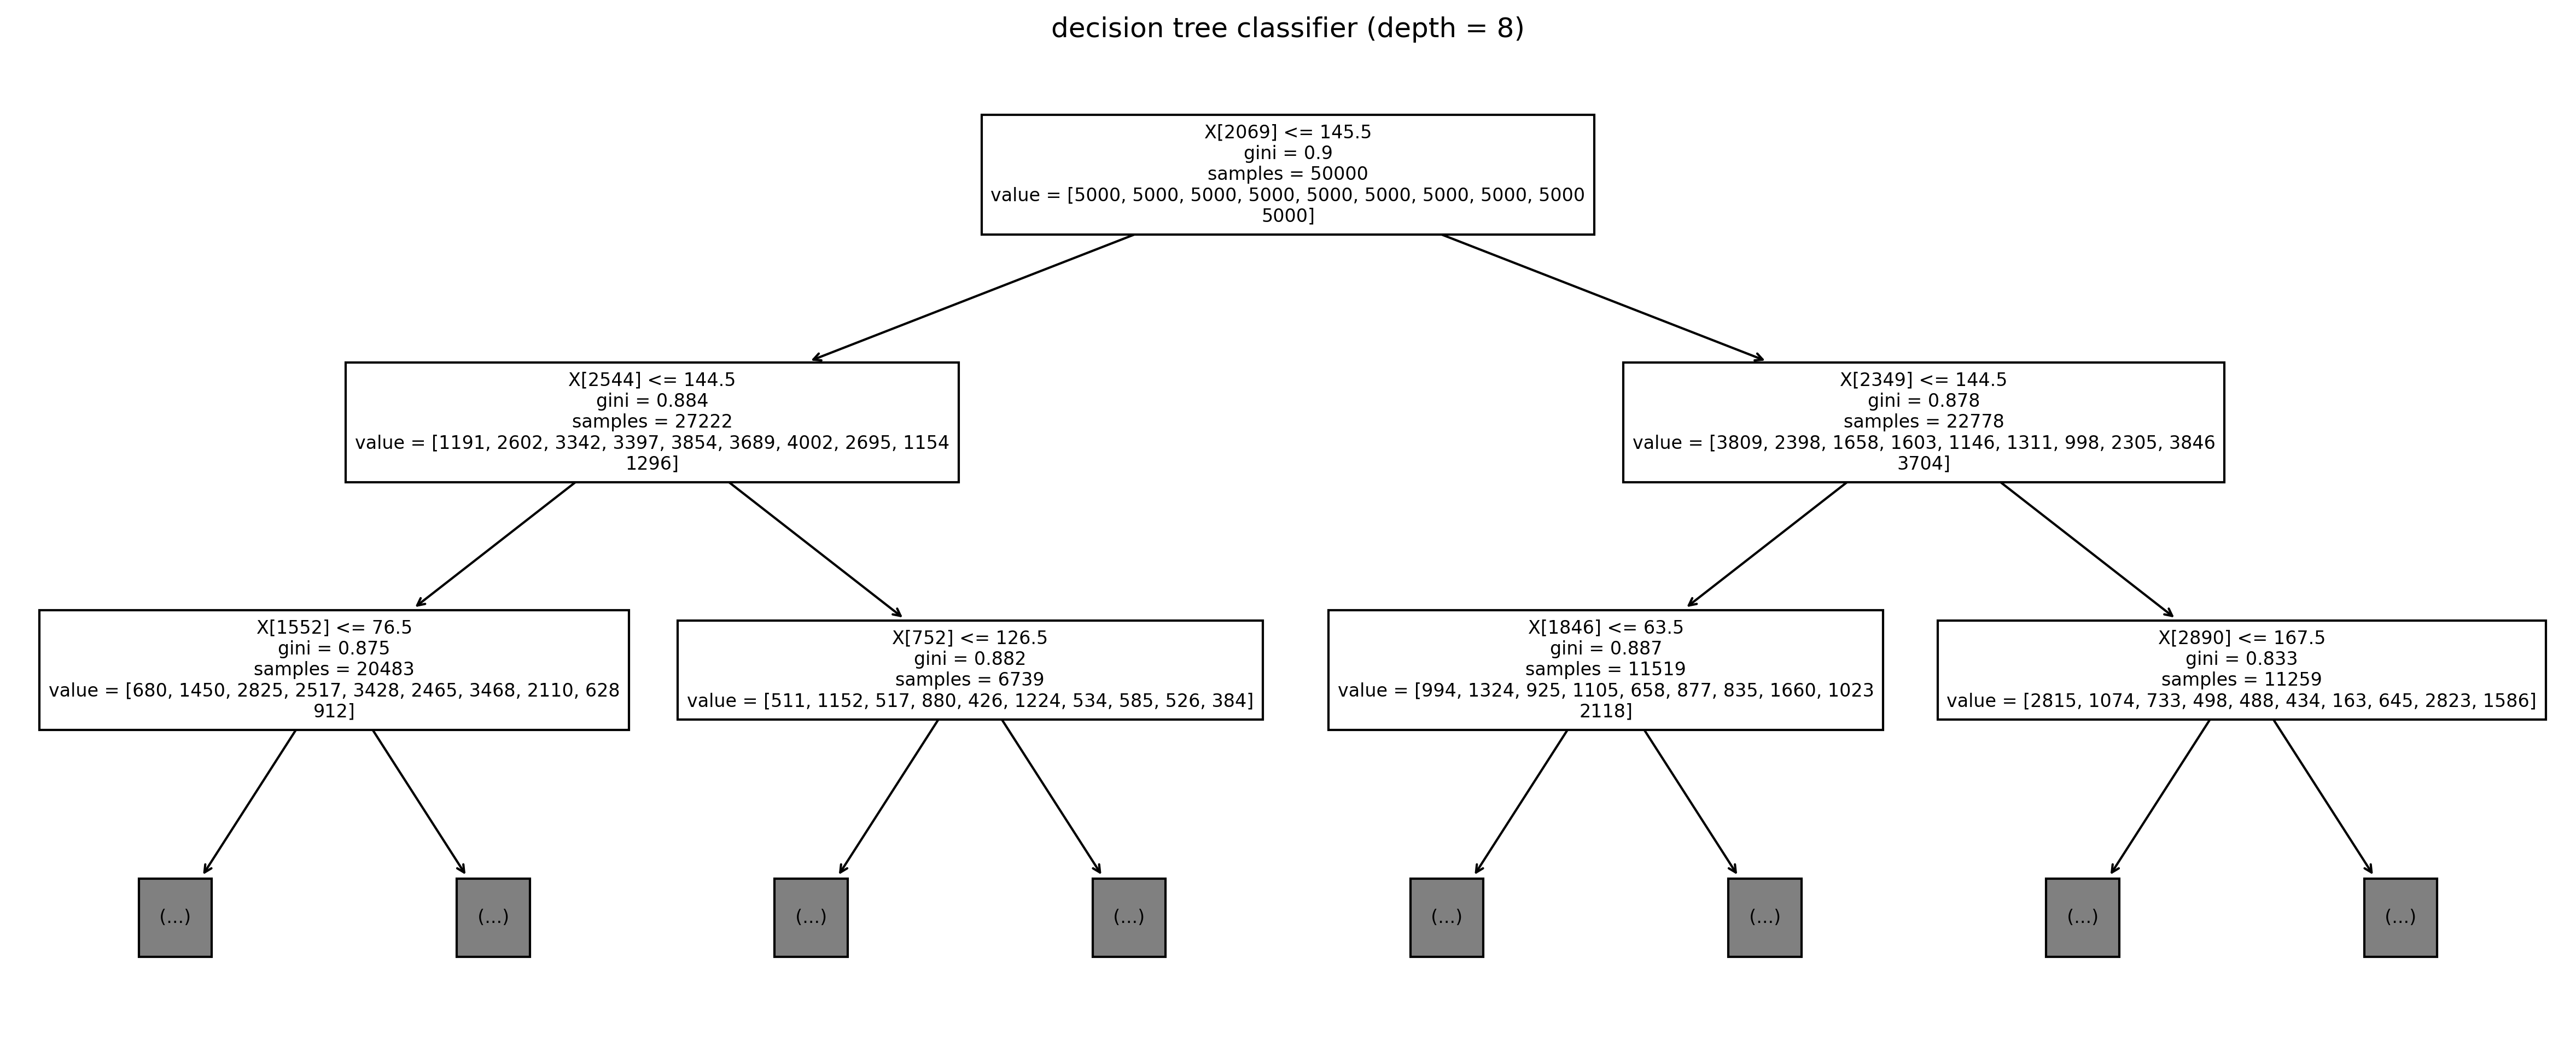

In [110]:
tree_depth = gridcv_best_estimator.get_depth()
plt.figure(figsize=(20,8), dpi=300)

plot_tree(decision_tree=gridcv_best_estimator,
        max_depth=2,    # only plot the top plot_depth layers
        rotate=True,
        fontsize=8)
plt.title('decision tree classifier (depth = ' + str(tree_depth) + ')')
plt.show()

**Run the code cell below**, which will take about a minute, to instanciate, train and print the classification report of the 'best' decision:

In [106]:
# Instanciate the best decition tree (max_depth=8, criterion='gini')
dt_best = DecisionTreeClassifier(max_depth=8, random_state=0, criterion='gini')
# tain the best decision tree
dt_best.fit(x_train, y_train)
# print the classification report
print(classification_report(y_test, dt_best.predict(x_test)))

              precision    recall  f1-score   support

           0       0.40      0.39      0.39      1000
           1       0.32      0.28      0.30      1000
           2       0.21      0.11      0.14      1000
           3       0.18      0.15      0.16      1000
           4       0.25      0.32      0.28      1000
           5       0.30      0.23      0.26      1000
           6       0.29      0.45      0.35      1000
           7       0.27      0.30      0.28      1000
           8       0.40      0.44      0.42      1000
           9       0.36      0.36      0.36      1000

    accuracy                           0.30     10000
   macro avg       0.30      0.30      0.30     10000
weighted avg       0.30      0.30      0.30     10000






Thank you!

Sources:
- https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search
- https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
